# EEMeter international

One critical problem is encountered when running EEMeter on datasets outside of the US: as it currently exists, EEMeter daily/billing does not account for unit conversion between Fahrenheit and Celsius.

EEMeter international adds a Celsius toggle to the 'original' eemeter, allowing for straightforward conversion between Fahrenheit (default) and Celsius. This does not affect the operation of original EEMeter, with all _defaults_ set to the 'original' US settings.

These amendments were developed by Carbon Co-op and enabled by Innovate UK grant number 10032096 in 2022. Carbon Co-op is a membership-based energy services co-operative in Manchester, UK. Innovate UK is the UK's national innovation agency and an agency of the UK Government. As such, this notebook is drafted from the perspective of a UK user; however it is envisaged that these amendments are applicable to most regions affected by the above issues when running EEMeter outside of the US.

## Unit conversion: EEMeter daily/billing

In order to construct a baseline model, EEMeter billing and daily models rely on the ability to choose one of four models: baseload-only, HDD* and CDD**, HDD-only, and CDD only. The latter two require electricity data, while the former two can operate with gas data only.

It is rare in the United Kingdom for residential dwellings to possess cooling systems, and most homes are currently heated by gas from the main network. Given the typical heating balance point for UK buildings lies at 15.5 degrees Celsius (Carbon Trust, 2012), it is to be expected that in the winter months the HDD model will be selected. However, since EEMeter daily/billing processes Fahrenheit data only, a 'baseload-only' model is returned. This issue is explained in eemeter issue no. 445 using sample data, and outlined in Figure 1 below.

HDD* = heating degree day

CDD** = cooling degree day

relevant 'original' modules with new 'region' toggle:
- `eemeter.create_caltrack_daily_design_matrix`
- `eemeter.create_caltrack_billing_design_matrix`
- `eemeter.metered_savings`

In [1]:
import eemeter

gas_us, temperature_data_us, metadata_us = eemeter.load_sample('il-gas-hdd-only-hourly', tempF=True)

In [2]:
gas_us

,value
start,
2015-11-22 06:00:00+00:00,0.06
2015-11-22 07:00:00+00:00,0.06
2015-11-22 08:00:00+00:00,0.12
2015-11-22 09:00:00+00:00,0.01
2015-11-22 10:00:00+00:00,0.09
...,...
2018-02-08 02:00:00+00:00,0.53
2018-02-08 03:00:00+00:00,0.02
2018-02-08 04:00:00+00:00,0.36


In [3]:
temperature_data_us

dt
2015-11-22 06:00:00+00:00    21.01
2015-11-22 07:00:00+00:00    20.35
2015-11-22 08:00:00+00:00    19.38
2015-11-22 09:00:00+00:00    19.02
2015-11-22 10:00:00+00:00    17.82
                             ...  
2018-02-08 02:00:00+00:00    17.06
2018-02-08 03:00:00+00:00    17.06
2018-02-08 04:00:00+00:00    17.05
2018-02-08 05:00:00+00:00    16.39
2018-02-08 06:00:00+00:00    15.99
Freq: H, Name: tempF, Length: 19417, dtype: float64

Running EEMeter daily for US data

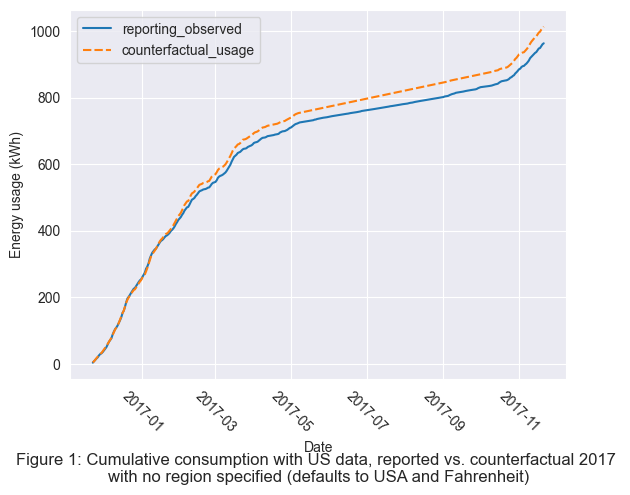

In [4]:
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
#running eemeter daily (see eemeter.caltrack.quickstart and eemeter.transform)
gas_us = eemeter.format_energy_data_for_caltrack(gas_us, method='daily')

metered_savings_dataframe_us = eemeter.caltrack_daily(meter_data=gas_us, 
                                                  temperature_data = temperature_data_us, 
                                                  blackout_start_date = gas_us.index.min() + relativedelta(years=1), 
                                                  blackout_end_date = gas_us.index.min() + relativedelta(years=1), 
                                                  degc=False,
                                                 )

sns.set_style('darkgrid')
msd_cumsum_us = metered_savings_dataframe_us.loc[:, ['reporting_observed', 'counterfactual_usage']].cumsum()
sns.lineplot(data=msd_cumsum_us)
plt.xticks(rotation=-45)
plt.ylabel('Energy usage (kWh)')
plt.xlabel('Date')
plt.legend()
plt.title('Figure 1: Cumulative consumption with US data, reported vs. counterfactual 2017 \n'
'with no region specified (defaults to USA and Fahrenheit)', y=-.3)
plt.show()

Running EEMeter daily for UK data (with 'degc=False' specified as per original EEMeter)

In [5]:
gas_uk, temperature_data_uk, metadata_uk = eemeter.load_sample('uk-gas-hdd-only-hourly-sample-0', tempF=False)

gas_uk

,value
start,
2020-04-01 01:00:00+00:00,0.0000
2020-04-01 02:00:00+00:00,0.0000
2020-04-01 03:00:00+00:00,0.0000
2020-04-01 04:00:00+00:00,0.0224
2020-04-01 05:00:00+00:00,0.0449
...,...
2022-12-06 08:00:00+00:00,0.0000
2022-12-06 09:00:00+00:00,0.0000
2022-12-06 10:00:00+00:00,0.0000


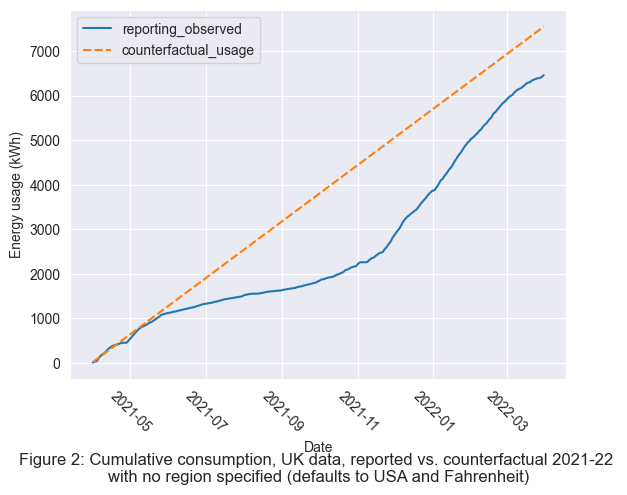

In [6]:
#note here the unit toggle is set to 'degc=False'. In this instance EEMeter is 'as is' without any conversion from Fahrenheit. 
#This means a set of HDD candidates are identified using a grid search of between 30C and 90C, 
#in which range is is extremely unlikely a heating balance point might lie.

gas_uk = eemeter.format_energy_data_for_caltrack(gas_uk, method='daily')

metered_savings_dataframe_uk = eemeter.caltrack_daily(
    meter_data=gas_uk, 
    temperature_data = temperature_data_uk, 
    blackout_start_date = gas_uk.index.min() + relativedelta(years=1), 
    blackout_end_date = gas_uk.index.min() + relativedelta(years=1), 
    degc=False,
)

sns.set_style('darkgrid')
msd_cumsum_uk = metered_savings_dataframe_uk.loc[:, ['reporting_observed', 'counterfactual_usage']].cumsum()
sns.lineplot(data=msd_cumsum_uk)
plt.xticks(rotation=-45)
plt.ylabel('Energy usage (kWh)')
plt.xlabel('Date')
plt.legend()
plt.title('Figure 2: Cumulative consumption, UK data, reported vs. counterfactual 2021-22 \n'
'with no region specified (defaults to USA and Fahrenheit)', y=-.3)
plt.show()

After specifying the correct units (...and amending the candidate balance point bins)

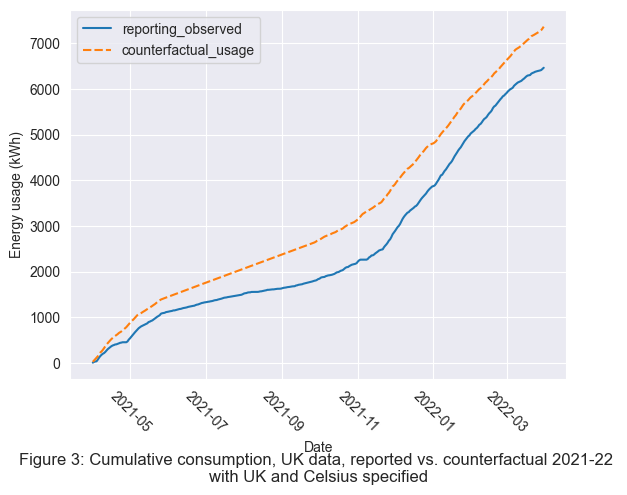

In [7]:
gas_uk = eemeter.format_energy_data_for_caltrack(gas_uk, method='daily')

metered_savings_dataframe_uk = eemeter.caltrack_daily(
    meter_data=gas_uk, 
    temperature_data = temperature_data_uk, 
    blackout_start_date = gas_uk.index.min() + relativedelta(years=1), 
    blackout_end_date = gas_uk.index.min() + relativedelta(years=1), 
    degc=True,
)
sns.set_style('darkgrid')
msd_cumsum_uk = metered_savings_dataframe_uk.loc[:, ['reporting_observed', 'counterfactual_usage']].cumsum()
sns.lineplot(data=msd_cumsum_uk)
plt.xticks(rotation=-45)
plt.ylabel('Energy usage (kWh)')
plt.xlabel('Date')
plt.legend()
plt.title('Figure 3: Cumulative consumption, UK data, reported vs. counterfactual 2021-22 \n'
'with UK and Celsius specified', y=-.3)
plt.show()